In [1325]:
pip install eikon

Note: you may need to restart the kernel to use updated packages.


In [1326]:
# Librerías necesarias
import eikon as ek
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Clave para acceder a la API de Refinitiv
ek.set_app_key('b451f4bb7f0a46b2bec224527ab9b78f460cc68f')


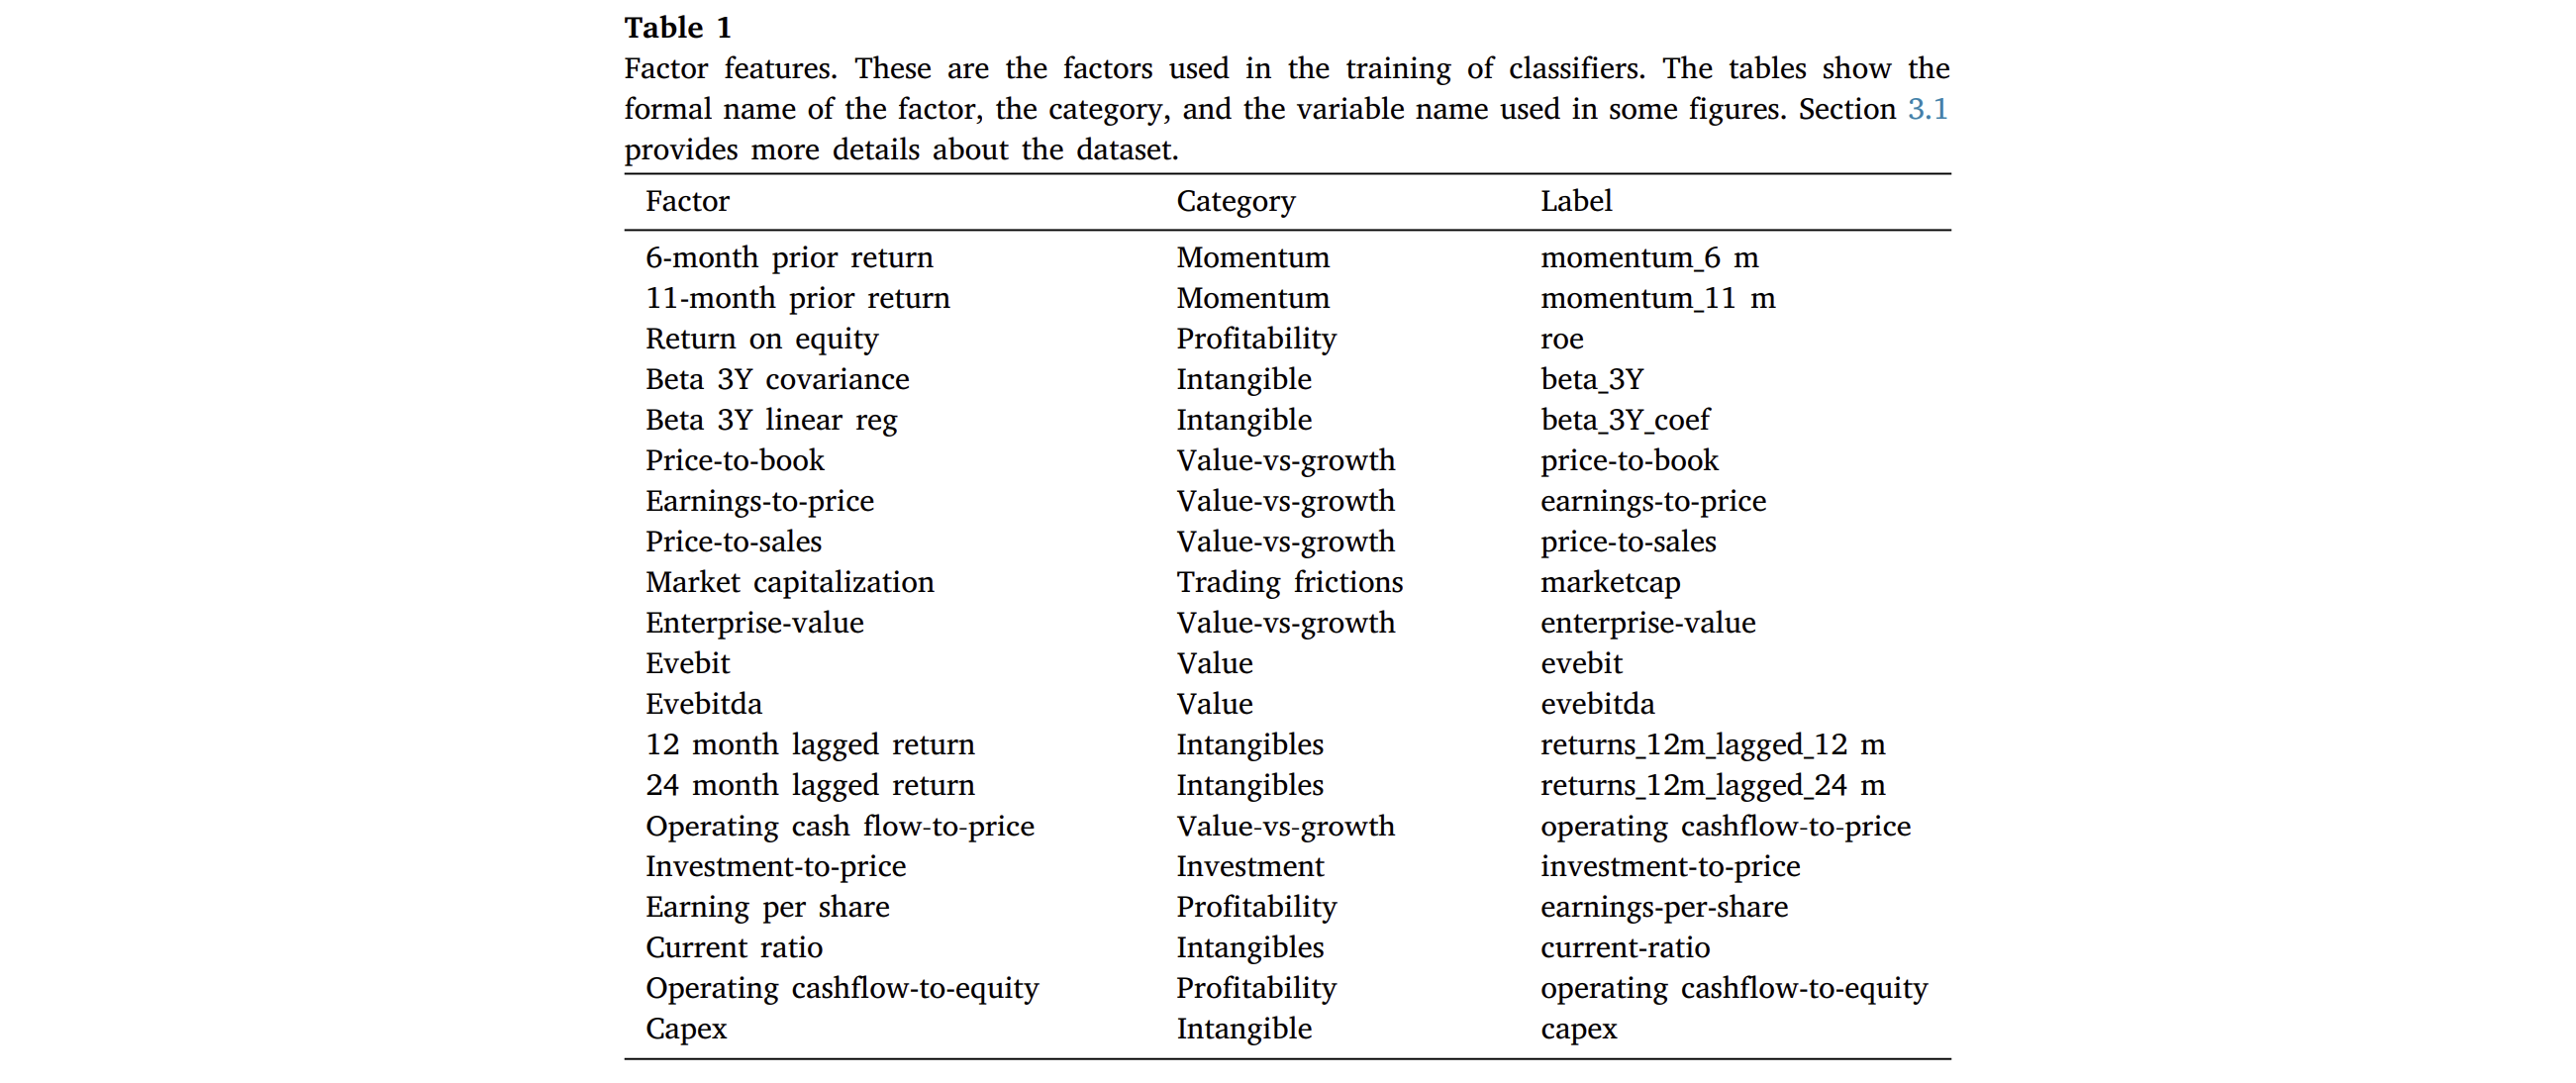

# 1. DESCARGA DE DATOS FINANCIEROS

__1.1. DESCARGA DE DATOS A TRAVÉS DE LA API DE EIKON__

El primer paso que se dió para llevar a cabo este estudio fue descargar los datos necesarios de una fuente financiera fiable. En este trabajo de investigación se utilizó la API de Refinitiv. El procedimiento seguido para llevar a cabo esta tarea fue el siguiente:

1) <u>Empresas</u>: Se definió `universo` como una lista de identificadores `rics` que representan a las compañías que conforman el EURO STOXX 50, y que se utilizarán posteriormente para obtener los datos financieros de cada empresa. En el contexto de Refinitiv Eikon, los RICs (Reuters Instrument Code) son códigos alfanuméricos que se utilizan para identificar de manera única los instrumentos financieros y los datos de mercado. 

2) <u>Periodo temporal</u>: Se definieron las fechas de inicio (`start_date`) y fin (`end_date`) del periodo para el cual se desean obtener los datos, y se estabreció la `frecuencia` de los datos. Todos estos parámetros, necesarios para realizar la consulta, se almacenan en un diccionario llamado `parametros`.

3) <u>Métricas financieras</u>: Se definió una lista denominada `fields` que incluye las métricas financieras específicas que se quieren obtener para cada empresa, elegidas por su relevancia para este estudio.

4) <u>Consulta de datos</u>: Se utilizó la función get_data() de la API de Eikon para obtener los datos financieros de las empresas seleccionadas (universo), con los campos (fields) y los parámetros definidos anteriormente. Los datos se almacenan en `df_ratios`, mientras que `err` captura cualquier posible error.


In [1329]:
# 1. Definir 'universo' como la lista de RICs de las compañías del Euro Stoxx 50
rics = rics = [
    "ASML.AS", "LVMH.PA", "TTEF.PA", "SAPG.DE", "SIEGn.DE", "SASY.PA", "OREP.PA", "SCHN.PA",
    "AIRP.PA", "ALVG.DE", "AIR.PA", "HRMS.PA", "IBE.MC", "DTEGn.DE", "SGEF.PA", "BNPP.PA",
    "MBGn.DE", "SAN.MC", "SAF.PA", "ESLX.PA", "AXAF.PA", "BAYGn.DE", "IFXGn.DE", "PRX.AS",
    "ABI.BR", "ENEI.MI", "MUVGn.DE", "INGA.AS", "ADYEN.AS", "DHLn.DE", "BBVA.MC", "BASFn.DE",
    "PERP.PA", "ISP.MI", "ITX.MC", "PRTP.PA", "CRDI.MI", "STLAM.MI", "CRH.L", "NDAFI.HE",
    "BMWG.DE", "DANO.PA", "FLTRF.L", "DB1Gn.DE", "ENI.MI", "AD.AS", "ADSGn.DE", "VOWG.DE",
    "NOKIA.HE", "VNAn.DE"
]
universo = rics

# 2. Definir los parámetros temporales
start_date = '2020-01-01'
end_date = '2024-12-31'
frecuencia = 'M'  # Mensual
parametros = {'SDate': start_date, 'EDate': end_date, 'Frq': frecuencia}

# 3. Definir las métricas financieras necesarias
fields = [
    'TR.F.ReturnAvgComEqPctTTM',
    'TR.FwdPriceToBVPerShare',
    'TR.FwdPtoEPSSmartEst',
    'TR.FwdPriceToSalesPerShare',
    'TR.CompanyMarketCapitalization',
    'TR.F.EV',
    'TR.FwdEVToEBIT',
    'TR.FwdEVToEBITDA'
    'TR.FwdPriceToCFPerShare',
    'TR.F.InvstTot',
    'TR.EPSMean',
    'TR.F.CurrRatio',
    'TR.F.OpCashFlowPctofCAPEX',
    'TR.F.CAPEXTot',
    'TR.PriceClose'
]

# 4. Obtener los datos para múltiples compañías y años
df_ratios, err = ek.get_data(universo, fields, parametros)

# Nota: Comprobar que no falta ninguna empresa del índice (50 empresas)
print('La lista de RICs contiene {} de 50 empresas del Euro Stoxx 50.'.format(len(rics)))

La lista de RICs contiene 50 de 50 empresas del Euro Stoxx 50.


C:\Users\Javi\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
C:\Users\Javi\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


# 2. AJUSTE DEL FORMATO DEL DATAFRAME

#### 2.1. CAMBIOS DE FORMATO REALIZADOS

A continuación se realizaron una serie de ajustes de formato sobre `df_ratios` con el objetivo de facilitar la interpretación y posterior aplicación de los algoritmos de Machine Learning. Se han llevado a cabo los siguentes cambios:

1) <u>Cambio del tipo de datos</u>: Se asegura que no haya problemas a la hora de operar con los datos convirtiendo todas las columnas numéricas del dataframe a tipo float (exceptuando la primera columna, que contiene los RICs de las empresas). Si se encuentran valores no numéricos, estos se convierten a `NaN` usando errors='coerce'.
   
2) <u>Cálculo y manejo de fechas</u>: Se sustituye el índice numérico del dataframe por un índice de tipo `Date` que contenga las fechas correspondientes a cada uno de los datos financieros obtenidos, y para cada una de las empresas seleccionadas. Para ello se siguieron los siguientes pasos:

   a) Se calculan cuántas fechas se requieren por empresa dividiendo el número total de registros entre la cantidad de empresas. Luego, se genera un rango de fechas de la frecuencia escogida (en este caso mensual) que va desde `start_date` hasta `end_date`, con el número de fechas necesarias para cubrir dicho período.

   b) Se crea una nueva columna en el dataframe con el nombre de 'Date' y se le asigna el rango de fechas generado. Esta columna contiene el mismo rango de fechas para todas las empresas. Por ejemplo, incluye los valores de la empresa Phillips para todos los datos financieros entre el 01/02/020 y el 01/01/2021, a continuación recoge esas mismas fechas pero para LVMH, y así sucesivamente. Esta estructura no es óptima y se simplificará en el siguiente apartado.

   c) Se aseguró que la columna 'Date' tuviera el formato adecuado de fechas (datetime) para trabajar con ellas adecuadamente en el análisis temporal.

3) <u>Forma de datos de panel</u>: Se utiliza el método pivot() para reorganizar el DataFrame y darle forma de datos de panel. Ahora, las fechas se convierten en el índice (cada fecha aparece una única vez como fila) y los ratios de cada una de las empresas pasan a ser las columnas, lo que facilita la visualización de los datos de cada empresa a lo largo del tiempo.

4) <u>Últimos ajustes y visualización</u>: Se renombra las columnas para que sean más legibles dándoles el siguiente formato: Empresa_Métrica. Donde 'Empresa' es cualquiera de los RICs que representan a las compañías escogidas y 'Métrica' es cualquiera de los datos financieros seleccionados. Por último, se aseguró que el índice del dataframe fuera la fecha y se visualizaron los primeros registros del nuevo Dataframe.

Se espera que el DataFrame resultante tenga 400 columnas (8 métricas * 50 empresas): ya que cada Empresa_Metrica tiene su propia columna.


In [1331]:
# 1. Convertir columnas numéricas de forma segura a FLOAT para evitar problemas de conversión
for col in df_ratios.columns[1:]:  # Evitar modificar la columna 'Instrument'
    df_ratios[col] = pd.to_numeric(df_ratios[col], errors='coerce').astype(float)  # Asegurar float

# 1. Cálculo y manejo de Fechas
    # a) Generar un rango de fechas basado en la frecuencia
    num_periodos = len(df_ratios) // len(universo)  # Cantidad de fechas esperadas
    fechas = pd.date_range(start=start_date, periods=num_periodos, freq='ME')  # Mantener 'M'
    # b) Agregar las fechas al DataFrame de forma repetitiva
    df_ratios['Date'] = fechas.tolist() * len(universo)
    # c) Convertir la columna de fechas a formato datetime
    df_ratios['Date'] = pd.to_datetime(df_ratios['Date'])

# 3. Pivotear el DataFrame para que cada empresa tenga sus propias columnas con los ratios
df_ratios_pivot = df_ratios.pivot(index='Date', columns='Instrument')

# Renombrar las columnas para que sean más legibles (Empresa_Métrica)
df_ratios_pivot.columns = [f"{empresa}_{col}" for col, empresa in df_ratios_pivot.columns]
# Asegurar que la fecha sea el índice
df_ratios_pivot.index.name = 'Date'
# Mostrar los primeros registros
df_ratios_pivot.head(15)

,"ABI.BR_Return on Average Common Equity - %, TTM","AD.AS_Return on Average Common Equity - %, TTM","ADSGn.DE_Return on Average Common Equity - %, TTM","ADYEN.AS_Return on Average Common Equity - %, TTM","AIR.PA_Return on Average Common Equity - %, TTM","AIRP.PA_Return on Average Common Equity - %, TTM","ALVG.DE_Return on Average Common Equity - %, TTM","ASML.AS_Return on Average Common Equity - %, TTM","AXAF.PA_Return on Average Common Equity - %, TTM","BASFn.DE_Return on Average Common Equity - %, TTM",...,SAN.MC_Price Close,SAPG.DE_Price Close,SASY.PA_Price Close,SCHN.PA_Price Close,SGEF.PA_Price Close,SIEGn.DE_Price Close,STLAM.MI_Price Close,TTEF.PA_Price Close,VNAn.DE_Price Close,VOWG.DE_Price Close
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,NaN,12.186456,26.863479,30.671763,53.121055,12.580457,12.033172,19.248079,2.226342,6.209111,...,3.376628,117.176232,86.496469,90.52,100.20,100.638994,9.461637,44.145,48.316018,165.6
2020-02-29,12.477266,12.492930,26.863479,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,3.160957,110.950436,83.492221,90.50,90.98,84.016072,9.066462,38.380,45.541175,152.3
2020-03-31,12.477266,12.492930,29.102778,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,2.107305,102.238301,79.721990,78.58,75.40,69.836106,5.300194,35.390,42.053872,121.4
2020-04-30,12.477266,12.492930,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,1.935813,108.344752,88.724785,83.46,74.70,76.335633,6.464753,32.850,42.231987,136.3
2020-05-31,NaN,13.717659,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,1.935813,112.879836,87.073444,89.24,83.04,88.820854,6.405074,33.625,48.541006,142.4
2020-06-30,NaN,13.717659,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,2.065976,123.640716,90.177170,98.88,82.00,94.436950,7.213168,33.975,51.165857,143.3
2020-07-31,-1.576386,13.717659,19.393761,31.222505,-102.284148,12.619210,11.704244,22.534657,5.483469,2.723276,...,1.718337,133.049026,88.088123,98.24,72.80,97.646147,6.951868,31.300,51.728325,132.7
2020-08-31,-1.576386,16.743152,9.898833,29.258738,-102.284148,12.619210,9.581963,22.534657,4.050004,2.723276,...,1.769832,137.285749,84.427318,103.75,78.58,104.262864,7.444628,33.100,56.246820,150.2
2020-09-30,-1.576386,16.743152,9.898833,29.258738,-102.284148,12.619210,9.581963,22.534657,4.050004,2.723276,...,1.519768,132.034599,84.884919,106.05,71.52,107.880000,8.442245,29.200,54.915645,149.2


# 3. Cálculos Adicionales

#### 3.1. CÁLCULO DEL RATIO INVESTMENT_TO_PRICE

Para calcular la métrica investment to price, utilizamos dos columnas clave que hemos descargado previamente: las columnas de Inversiones Totales y Precio de Cierre para cada empresa del Eurostoxx 50. El investment to price se calcula dividiendo el valor total de las inversiones de una empresa entre el precio de su acción. Esta métrica proporciona una visión de la relación entre las inversiones de una empresa y el valor de su acción, lo cual es útil para evaluar su eficiencia de capital.

1) <u>Crear DataFrame vacío para guardar las nuevas columnas</u>: Se crea un nuevo DataFrame vacío denominado `ivestment_to_price` que almacenará las nuevas columnas de investment to price para cada empresa.

2) <u>Filtrar columnas que terminan con los nombres que nos interesan</u>: Se filtran las columnas del DataFrame que contienen la información de Inversiones Totales y Precio de Cierre para cada empresa.

3) <u>Asegurar que estamos emparejando por empresa</u>: Se realiza un ciclo para emparejar las columnas de Inversiones Totales con las correspondientes de Precio de Cierre para cada empresa. Si ambas columnas existen, se calcula la métrica investment to price.

4) <u>Combinar con el DataFrame original</u>: Finalmente, las nuevas columnas de investment to price se concatenan con el DataFrame original, `df_ratios_pivot`, para completar el análisis.


In [1333]:
# 1) Crear DataFrame vacío para guardar las nuevas columnas
investment_to_price = pd.DataFrame(index=df_ratios_pivot.index)

# 2) Filtrar columnas que terminan con los nombres que nos interesan
invest_cols = [col for col in df_ratios_pivot.columns if col.endswith('Investments - Total')]
price_cols = [col for col in df_ratios_pivot.columns if col.endswith('Price Close')]

# 3) Asegurar que estamos emparejando por empresa
for invest_col in invest_cols:
    # Obtener el nombre base de la empresa
    empresa = invest_col.split('_')[0]  # Ej: "ASML.AS"
    
    # Buscar su columna de precio
    matching_price_cols = [col for col in price_cols if col.startswith(empresa)]
    
    if matching_price_cols:
        price_col = matching_price_cols[0]
        new_col = f"{empresa}_investment_to_price"
        
        # Calcular y añadir la nueva columna
        investment_to_price[new_col] = df_ratios_pivot[invest_col] / df_ratios_pivot[price_col]
    else:
        print(f"No se encontró columna de precio para {empresa}")

# 4) Combinar con el DataFrame original
df_ratios_pivot = pd.concat([df_ratios_pivot, investment_to_price], axis=1)

# Ver resultado
df_ratios_pivot.head()


,"ABI.BR_Return on Average Common Equity - %, TTM","AD.AS_Return on Average Common Equity - %, TTM","ADSGn.DE_Return on Average Common Equity - %, TTM","ADYEN.AS_Return on Average Common Equity - %, TTM","AIR.PA_Return on Average Common Equity - %, TTM","AIRP.PA_Return on Average Common Equity - %, TTM","ALVG.DE_Return on Average Common Equity - %, TTM","ASML.AS_Return on Average Common Equity - %, TTM","AXAF.PA_Return on Average Common Equity - %, TTM","BASFn.DE_Return on Average Common Equity - %, TTM",...,SAN.MC_investment_to_price,SAPG.DE_investment_to_price,SASY.PA_investment_to_price,SCHN.PA_investment_to_price,SGEF.PA_investment_to_price,SIEGn.DE_investment_to_price,STLAM.MI_investment_to_price,TTEF.PA_investment_to_price,VNAn.DE_investment_to_price,VOWG.DE_investment_to_price
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,NaN,12.186456,26.863479,30.671763,53.121055,12.580457,12.033172,19.248079,2.226342,6.209111,...,8.758383e+10,1.967122e+07,2.713406e+07,8.174989e+06,369261.477046,3.071374e+07,3.878821e+07,1.154604e+08,9.170416e+08,2.243780e+08
2020-02-29,12.477266,12.492930,26.863479,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,9.355964e+10,2.077504e+07,1.622906e+07,8.165746e+06,582545.614421,3.679058e+07,6.926627e+07,1.607608e+08,9.729174e+08,2.439724e+08
2020-03-31,12.477266,12.492930,29.102778,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,1.403395e+11,2.254537e+07,1.699657e+07,9.404429e+06,702917.771883,4.426077e+07,1.184862e+08,1.743430e+08,1.260157e+09,3.045964e+08
2020-04-30,12.477266,12.492930,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,1.527720e+11,2.127468e+07,1.527194e+07,8.854541e+06,709504.685408,4.049223e+07,9.714214e+07,1.878234e+08,1.254843e+09,2.712986e+08
2020-05-31,NaN,13.717659,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,1.527720e+11,2.041994e+07,1.556158e+07,8.281040e+06,638246.628131,3.480039e+07,9.804727e+07,1.834944e+08,1.091747e+09,2.596770e+08


#### 3.2. CÁLCULO DE MOMENTUM(s) Y RETORNOS LAGEADOS

__3.2.1. Cálculo de retornos logarítmicos__

Para poder calcular los momentum(s) y los retornos laggeados debemos se deben primero calcular los retornos logarítmicos de las empresas (`log_returns`). Los retornos logarítmicos son una medida de rentabilidad relativa entre dos precios consecutivos, calculada como el logaritmo natural de la relación entre el precio actual y el anterior. Son útiles en este contexto porque estabilizan la varianza, permitiendo un análisis más robusto en comparación con los retornos aritméticos, que no consideran los efectos de la compounding y pueden distorsionar los resultados, especialmente en periodos largos o con alta volatilidad. Esto facilita la comparación entre diferentes activos o mercados.

En este sentido, los retornos logarítmicos proporcionan una medición más precisa y fiable, lo que es esencial al calcular el beta, que mide la relación entre los retornos de un activo y los del mercado, como el Eurostoxx 50. Este enfoque asegura un análisis más consistente de la volatilidad y la relación del activo con el mercado.

La fórmula de los retornos logarítmicos es la siguiente:

$$
\text{Log Return} = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

donde:
- \( P_t \) es el precio del activo en el tiempo \( t \).
- \( P_{t-1} \) es el precio del activo en el tiempo \( t-1 \).

Se han seguido los siguientes pasos:



1) <u>Filtrar las columnas de precios</u>: Se seleccionan las columnas del DataFrame que contienen los precios de cierre, las cuales tienen el sufijo `Price Close`. Estas columnas se filtran y se copian en un nuevo DataFrame.

2) <u>Ordenar por fecha</u>: Se asegura que las fechas en el DataFrame estén correctamente ordenadas, para que los cálculos posteriores de retornos y momentum se realicen de manera adecuada.

3) <u>Cálculo de retornos logarítmicos</u>: Se calculan los retornos logarítmicos de los precios de cierre, lo que permite obtener una medida de la rentabilidad relativa entre periodos consecutivos.

4) <u>Renombrar las columnas</u>: Se renombran las columnas que contienen los retornos logarítmicos, reemplazando `Price Close` por `Log Return`, para mantener la claridad en el DataFrame.

5) <u>Agregar los retornos logarítmicos al DataFrame original</u>: Se concatenan los retornos logarítmicos calculados con el DataFrame original, `df_ratios_pivot`, lo que facilita su análisis posterior.

In [1335]:
# 1. Filtrar columnas de precio
price_cols = [col for col in df_ratios_pivot.columns if col.endswith('Price Close')]
df_prices = df_ratios_pivot[price_cols].copy()

# 2. Asegurar que están ordenados por fecha
df_prices.sort_index(inplace=True)

# 3. Calcular retornos logarítmicos
log_returns = np.log(df_prices / df_prices.shift(1))

# 4. Renombrar columnas para indicar que son retornos log
log_returns.columns = [col.replace('Price Close', 'Log Return') for col in log_returns.columns]

# 5. Agregar al DataFrame original
df_ratios_pivot = pd.concat([df_ratios_pivot, log_returns], axis=1)

# Visualizar el resultado
df_ratios_pivot.head()


,"ABI.BR_Return on Average Common Equity - %, TTM","AD.AS_Return on Average Common Equity - %, TTM","ADSGn.DE_Return on Average Common Equity - %, TTM","ADYEN.AS_Return on Average Common Equity - %, TTM","AIR.PA_Return on Average Common Equity - %, TTM","AIRP.PA_Return on Average Common Equity - %, TTM","ALVG.DE_Return on Average Common Equity - %, TTM","ASML.AS_Return on Average Common Equity - %, TTM","AXAF.PA_Return on Average Common Equity - %, TTM","BASFn.DE_Return on Average Common Equity - %, TTM",...,SAN.MC_Log Return,SAPG.DE_Log Return,SASY.PA_Log Return,SCHN.PA_Log Return,SGEF.PA_Log Return,SIEGn.DE_Log Return,STLAM.MI_Log Return,TTEF.PA_Log Return,VNAn.DE_Log Return,VOWG.DE_Log Return
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,NaN,12.186456,26.863479,30.671763,53.121055,12.580457,12.033172,19.248079,2.226342,6.209111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,12.477266,12.492930,26.863479,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,-0.066003,-0.054595,-0.035350,-0.000221,-0.096528,-0.180532,-0.042663,-0.139943,-0.059146,-0.083723
2020-03-31,12.477266,12.492930,29.102778,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,-0.405465,-0.081777,-0.046208,-0.141233,-0.187832,-0.184857,-0.536839,-0.081107,-0.079665,-0.226761
2020-04-30,12.477266,12.492930,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,-0.084882,0.058012,0.106994,0.060250,-0.009327,0.088989,0.198621,-0.074478,0.004226,0.115767
2020-05-31,NaN,13.717659,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,0.000000,0.041006,-0.018787,0.066962,0.105842,0.151482,-0.009274,0.023318,0.139231,0.043782


__3.2.2. Cálculo del Momentum y Retornos Lageados__

Una vez que se han calculado los retornos logarítmicos, el siguiente paso es calcular el momentum y los retornos laggeados. El momentum mide la fuerza de una tendencia en los precios, y se calcula como la suma de los retornos logarítmicos durante un periodo determinado. Los retornos laggeados, por su parte, reflejan los rendimientos de un activo en periodos previos, permitiendo analizar cómo el comportamiento pasado puede influir en el rendimiento futuro.

1) <u>Crear un DataFrame para el Momentum</u>: Se crea un nuevo DataFrame denominado `momentum_df`que almacenará los valores del momentum y los retornos laggeados, utilizando el mismo índice temporal que el DataFrame de los retornos logarítmicos. Esto asegura que los cálculos se mantengan consistentes con los datos de los retornos previos.

2) <u>Calcular el Momentum de 6 meses</u>: Se calcula el momentum de 6 meses sobre los retornos logarítmicos. Esto se hace sumando los retornos logarítmicos de los últimos 6 meses, lo que permite evaluar la magnitud y la dirección de la tendencia a corto plazo.

3) <u>Calcular el Momentum de 11 meses</u>: De manera similar, se calcula el momentum de 11 meses, utilizando la misma técnica de suma de los retornos logarítmicos de los últimos 11 meses. Este cálculo ofrece una visión más amplia de la tendencia del activo a medio plazo.

4) <u>Calcular los retornos laggeados de 12 y 24 meses</u>: Se calcula el retorno laggeado de 12 meses y 24 meses, que muestra el rendimiento de los precios en esos periodos previos. Este análisis ayuda a identificar cómo los rendimientos pasados influyen en el comportamiento actual del activo, brindando una perspectiva más completa sobre su evolución temporal.

5) <u>Concatenar los resultados al dataframe original</u>: Se añaden las cuatro columnas recién calculadas al dataframe original que contenía el resto de datos financieros de las empresas del Euro Stoxx 50.

In [1337]:
# Crear un diccionario para las nuevas columnas
momentum_columns = {}

# Calcular el Momentum de 6 meses sobre los retornos logarítmicos
for column in log_returns.columns:
    momentum_columns[column + '_momentum_6m'] = log_returns[column].shift(1).rolling(window=6).sum()

# Calcular el Momentum de 11 meses sobre los retornos logarítmicos
for column in log_returns.columns:
    momentum_columns[column + '_momentum_11m'] = log_returns[column].shift(1).rolling(window=11).sum()

# Calcular los retornos laggeados (12 meses y 24 meses)
for column in log_returns.columns:
    momentum_columns[column + '_returns_12m_lagged'] = log_returns[column].shift(12)
    momentum_columns[column + '_returns_24m_lagged'] = log_returns[column].shift(24)

# Crear un nuevo DataFrame con todas las columnas de momentum y lagged
momentum_df = pd.DataFrame(momentum_columns)

# Concatenar el DataFrame original con el DataFrame de momentum
df_ratios_pivot = pd.concat([df_ratios_pivot, momentum_df], axis=1)

# Ver el resultado
df_ratios_pivot.head(26)


,"ABI.BR_Return on Average Common Equity - %, TTM","AD.AS_Return on Average Common Equity - %, TTM","ADSGn.DE_Return on Average Common Equity - %, TTM","ADYEN.AS_Return on Average Common Equity - %, TTM","AIR.PA_Return on Average Common Equity - %, TTM","AIRP.PA_Return on Average Common Equity - %, TTM","ALVG.DE_Return on Average Common Equity - %, TTM","ASML.AS_Return on Average Common Equity - %, TTM","AXAF.PA_Return on Average Common Equity - %, TTM","BASFn.DE_Return on Average Common Equity - %, TTM",...,SIEGn.DE_Log Return_returns_12m_lagged,SIEGn.DE_Log Return_returns_24m_lagged,STLAM.MI_Log Return_returns_12m_lagged,STLAM.MI_Log Return_returns_24m_lagged,TTEF.PA_Log Return_returns_12m_lagged,TTEF.PA_Log Return_returns_24m_lagged,VNAn.DE_Log Return_returns_12m_lagged,VNAn.DE_Log Return_returns_24m_lagged,VOWG.DE_Log Return_returns_12m_lagged,VOWG.DE_Log Return_returns_24m_lagged
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,NaN,12.186456,26.863479,30.671763,53.121055,12.580457,12.033172,19.248079,2.226342,6.209111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,12.477266,12.492930,26.863479,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31,12.477266,12.492930,29.102778,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-30,12.477266,12.492930,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-31,NaN,13.717659,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-30,NaN,13.717659,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-31,-1.576386,13.717659,19.393761,31.222505,-102.284148,12.619210,11.704244,22.534657,5.483469,2.723276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-31,-1.576386,16.743152,9.898833,29.258738,-102.284148,12.619210,9.581963,22.534657,4.050004,2.723276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-30,-1.576386,16.743152,9.898833,29.258738,-102.284148,12.619210,9.581963,22.534657,4.050004,2.723276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.3. CÁLCULO DEL BETA 3Y COVARIANZA

__3.3.1. Preprocesamiento datos del Euro Stoxx 50__

En este primer bloque de código se prepara la serie temporal de precios del índice Eurostoxx 50 con el objetivo de calcular sus retornos logarítmicos, que luego se utilizarán como benchmark para calcular el Beta 3Y Covarianza. Se han seguido los siguientes pasos:

1) <u>Selección del índice y campo</u>: se define el identificador del Eurostoxx 50 (.STOXX50E) y se solicita el campo de precio de cierre ('TR.PriceClose') a través de la función ek.get_data().

2) <u>Generación de fechas</u>: a partir de la fecha de inicio (start_date) se crea un rango de fechas con una frecuencia mensual ('ME') y el número de periodos que coincida con las observaciones descargadas (en este caso, 48 meses).

3) <u>Conversión de datos</u>: para evitar errores en cálculos posteriores, se convierte la columna de precios de cierre a formato numérico (float), gestionando posibles errores con errors='coerce'.

4) <u>Cálculo de retornos logarítmicos</u>: se utiliza la fórmula log(P_t / P_{t-1}) para calcular los retornos mensuales. Esta transformación es habitual en finanzas, ya que estabiliza la varianza y permite análisis más robustos.

5) <u>Estructuración del DataFrame</u>: se incorpora la columna de retornos al DataFrame y se establece la columna 'Date' como índice temporal. Esto facilita su manipulación en análisis de series de tiempo.


In [1339]:
# 1) Selección del índice y campo
# Definir el símbolo del Eurostoxx ('.STOXX50E') y el campo de precios de cierre
eurostoxx = ['.STOXX50E']
fields_eurostoxx = ['TR.PriceClose']
# Obtener los datos de Eurostoxx
df_eurostoxx, err = ek.get_data(eurostoxx, fields_eurostoxx, parametros)
# Verificar cuántas filas tiene el DataFrame
num_periodos = len(df_eurostoxx)  # Número de filas (48)

# 2) Generación de fechas
# Generar el rango de fechas con el número correcto de periodos (48)
fechas = pd.date_range(start=start_date, periods=num_periodos, freq='ME')
# Asignar las fechas al DataFrame
df_eurostoxx['Date'] = fechas

# 3) Conversión de datos
# Asegurarse de que las columnas sean numéricas para evitar problemas de conversión
df_eurostoxx['Price Close'] = pd.to_numeric(df_eurostoxx['Price Close'], errors='coerce')

# 4) Calcular los retornos logarítmicos
# Cálculo
log_returns_eurostoxx = np.log(df_eurostoxx['Price Close'] / df_eurostoxx['Price Close'].shift(1))

# 5) Estructuración del Dataframe
# Añadir los retornos logarítmicos al DataFrame
df_eurostoxx['Log Return'] = log_returns_eurostoxx
# Establecer la columna 'Date' como el índice del DataFrame
df_eurostoxx.set_index('Date', inplace=True)

# Mostrar el resultado
df_eurostoxx.head()


,Instrument,Price Close,Log Return
Date,,,
2020-01-31,.STOXX50E,3640.91,<NA>
2020-02-29,.STOXX50E,3329.49,-0.089415
2020-03-31,.STOXX50E,2786.9,-0.177889
2020-04-30,.STOXX50E,2927.93,0.049366
2020-05-31,.STOXX50E,3050.2,0.040911


__3.3.2. Definición y construcción de la matriz del beta__

Este segundo bloque de código tiene como objetivo calcular el Beta a 3 años (36 meses) de las distintas empresas respecto al índice Eurostoxx 50. Para ello se utiliza la definición estadística clásica de beta: cociente entre la covarianza de los retornos de la empresa (R_i) con los del índice (R_m) y la varianza de los retornos del índice. Su fórmula es la siguiente:

$$
\beta = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}
$$
donde:
- \( R_i \) son los retornos del activo o empresa
- \( R_m \) son los retornos del mercado (en este caso, el Eurostoxx 50)

Se han seguido los siguientes pasos:

1) <u>Preparación de datos</u>: se toman los retornos logarítmicos de las empresas (log_returns) y del índice (log_returns_index), calculados previamente.

2) <u>Inicialización del DataFrame de betas</u>: se crea un DataFrame vacío con las mismas fechas como índice, para almacenar los valores de beta de cada empresa.

3) <u>Cálculo de beta por covarianza</u>:

   a) Se calcula la covarianza móvil entre cada empresa y el índice con una ventana de 36 meses.

   b) Se calcula la varianza móvil del índice en la misma ventana.

   c) Se obtiene el Beta 3Y dividiendo ambos valores.

5) <u>Tratamiento de datos faltantes</u>: se asegura que todos los valores sean numéricos y se eliminan filas con valores NaN que puedan afectar los resultados.
   
6) <u>Unión de resultados</u>: finalmente, se renombran las columnas para identificar claramente que son Betas calculadas por covarianza, y se incorporan al DataFrame principal df_ratios_pivot.


In [1341]:
# 1) Preparación de datos
periodos_3y = 36  # Definir la ventana de 3 años (36 meses)
log_returns_index = df_eurostoxx['Log Return']  # Retornos del índice

# 2) Inicialización del DataFrame de betas
beta_3y_combined = pd.DataFrame(index=log_returns.index)

# 3) Cálculo del Beta 3Y por covarianza
for column in log_returns.columns:
    # a) Covarianza móvil con el índice
    covariance = log_returns[column].rolling(window=periodos_3y).cov(log_returns_index)
    
    # b) Varianza móvil del índice
    variance_index = log_returns_index.rolling(window=periodos_3y).var()
    
    # c) Beta 3Y = covarianza / varianza
    beta_3y_combined[column + '_beta_3Y_covariance'] = covariance / variance_index

# 4) Tratamiento de datos faltantes
log_returns = log_returns.apply(pd.to_numeric, errors='coerce')
log_returns_index = pd.to_numeric(log_returns_index, errors='coerce')
log_returns = log_returns.dropna()
log_returns_index = log_returns_index.dropna()

# 5) Unión de resultados
beta_3y_combined = beta_3y_combined.rename(columns=lambda x: x + '_cov')
df_ratios_pivot = df_ratios_pivot.join(beta_3y_combined, how='left')

# Visualizar
df_ratios_pivot.head(48)

,"ABI.BR_Return on Average Common Equity - %, TTM","AD.AS_Return on Average Common Equity - %, TTM","ADSGn.DE_Return on Average Common Equity - %, TTM","ADYEN.AS_Return on Average Common Equity - %, TTM","AIR.PA_Return on Average Common Equity - %, TTM","AIRP.PA_Return on Average Common Equity - %, TTM","ALVG.DE_Return on Average Common Equity - %, TTM","ASML.AS_Return on Average Common Equity - %, TTM","AXAF.PA_Return on Average Common Equity - %, TTM","BASFn.DE_Return on Average Common Equity - %, TTM",...,SAN.MC_Log Return_beta_3Y_covariance_cov,SAPG.DE_Log Return_beta_3Y_covariance_cov,SASY.PA_Log Return_beta_3Y_covariance_cov,SCHN.PA_Log Return_beta_3Y_covariance_cov,SGEF.PA_Log Return_beta_3Y_covariance_cov,SIEGn.DE_Log Return_beta_3Y_covariance_cov,STLAM.MI_Log Return_beta_3Y_covariance_cov,TTEF.PA_Log Return_beta_3Y_covariance_cov,VNAn.DE_Log Return_beta_3Y_covariance_cov,VOWG.DE_Log Return_beta_3Y_covariance_cov
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,NaN,12.186456,26.863479,30.671763,53.121055,12.580457,12.033172,19.248079,2.226342,6.209111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,12.477266,12.492930,26.863479,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31,12.477266,12.492930,29.102778,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-30,12.477266,12.492930,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-31,NaN,13.717659,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-30,NaN,13.717659,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-31,-1.576386,13.717659,19.393761,31.222505,-102.284148,12.619210,11.704244,22.534657,5.483469,2.723276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-31,-1.576386,16.743152,9.898833,29.258738,-102.284148,12.619210,9.581963,22.534657,4.050004,2.723276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-30,-1.576386,16.743152,9.898833,29.258738,-102.284148,12.619210,9.581963,22.534657,4.050004,2.723276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.4. CÁLCULO DEL BETA 3Y REGRESIÓN LINEAL

En esta sección se calcula el Beta a 3 años (36 meses) de cada empresa con respecto al índice Eurostoxx 50, aplicando un enfoque de regresión lineal. En lugar de usar directamente la fórmula estadística de covarianza y varianza, se realiza una regresión lineal simple para cada ventana móvil de 36 meses, donde el coeficiente beta representa la pendiente de la recta ajustada.

La ecuación del modelo es:

$$
R_i = \alpha + \beta R_m + \varepsilon
$$

donde:

- $R_i$ son los retornos logarítmicos de la empresa (variable dependiente),
- $R_m$ son los retornos logarítmicos del índice (variable independiente),
- $\beta$ es el coeficiente de sensibilidad (beta),
- $\alpha$ es el intercepto de la regresión,
- $\varepsilon$ es el término de error.


Se han seguido los siguientes pasos:

1) <u>Inicialización del DataFrame de betas</u>: se crea un DataFrame vacío beta_3y_regression con el mismo índice temporal para guardar los betas estimados.

2) <u>Aplicación de regresión lineal móvil</u>:

   a) Para cada empresa, se recorre el índice temporal aplicando una ventana deslizante de 36 meses.

   b) Para cada ventana, se extraen los retornos correspondientes de la empresa y del índice.

   c) Se estructura la matriz de regresores ($X$) y la variable dependiente ($Y$), asegurando el formato numérico correcto.

   d) Se añade un intercepto al modelo (sm.add_constant) y se ajusta la regresión con statsmodels.

   e) Se extrae el coeficiente beta ($\beta$) como la pendiente de la recta y se guarda en una lista.

   f) Finalmente, los valores obtenidos se insertan como columna en el DataFrame principal.

3) <u>Unión de resultados</u>: se incorporan los betas calculados por regresión al DataFrame df_ratios_pivot.

In [1343]:
for column in log_returns.columns:
    beta_3y_values = []

    for end_date in log_returns.index[periodos_3y-1:]:
        start_date = end_date - pd.DateOffset(months=periodos_3y)

        window_returns = log_returns.loc[start_date:end_date, column]
        window_index = log_returns_index.loc[start_date:end_date]

        combined = pd.concat([window_index, window_returns], axis=1).dropna()

        if len(combined) < 10:
            beta_3y_values.append(np.nan)
            continue

        X = combined.iloc[:, 0].values.reshape(-1, 1)
        Y = combined.iloc[:, 1].values.reshape(-1, 1)

        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()

        beta_3y_values.append(model.params[1])

    beta_3y_regression[column + '_beta_3Y_regression'] = pd.Series(
        beta_3y_values, index=log_returns.index[periodos_3y-1:]
    )

df_ratios_pivot.head(48)

,"ABI.BR_Return on Average Common Equity - %, TTM","AD.AS_Return on Average Common Equity - %, TTM","ADSGn.DE_Return on Average Common Equity - %, TTM","ADYEN.AS_Return on Average Common Equity - %, TTM","AIR.PA_Return on Average Common Equity - %, TTM","AIRP.PA_Return on Average Common Equity - %, TTM","ALVG.DE_Return on Average Common Equity - %, TTM","ASML.AS_Return on Average Common Equity - %, TTM","AXAF.PA_Return on Average Common Equity - %, TTM","BASFn.DE_Return on Average Common Equity - %, TTM",...,SAN.MC_Log Return_beta_3Y_covariance_cov,SAPG.DE_Log Return_beta_3Y_covariance_cov,SASY.PA_Log Return_beta_3Y_covariance_cov,SCHN.PA_Log Return_beta_3Y_covariance_cov,SGEF.PA_Log Return_beta_3Y_covariance_cov,SIEGn.DE_Log Return_beta_3Y_covariance_cov,STLAM.MI_Log Return_beta_3Y_covariance_cov,TTEF.PA_Log Return_beta_3Y_covariance_cov,VNAn.DE_Log Return_beta_3Y_covariance_cov,VOWG.DE_Log Return_beta_3Y_covariance_cov
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,NaN,12.186456,26.863479,30.671763,53.121055,12.580457,12.033172,19.248079,2.226342,6.209111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,12.477266,12.492930,26.863479,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31,12.477266,12.492930,29.102778,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-30,12.477266,12.492930,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-31,NaN,13.717659,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-30,NaN,13.717659,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-31,-1.576386,13.717659,19.393761,31.222505,-102.284148,12.619210,11.704244,22.534657,5.483469,2.723276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-31,-1.576386,16.743152,9.898833,29.258738,-102.284148,12.619210,9.581963,22.534657,4.050004,2.723276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-30,-1.576386,16.743152,9.898833,29.258738,-102.284148,12.619210,9.581963,22.534657,4.050004,2.723276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4.LIMPIEZA DEL DATASET FINAL

Antes de continuar se eliminan las columnas no necesarias para realizar el estudio...

Quitar NaN del principio y dejar la tabla desde el primer año que tenga todos los valores completos. A partid de ahí limpiar el resto de la tabla de posibles NaN. Por último, tratar y estudiar atípicos (hacer quizás boxplot's) en cada empresa.


In [1345]:
# 1) Filtrar las columnas que contienen 'Investments - Total' o 'Price Close' o 'Log Return' exactamente
cols_to_drop = [col for col in df_ratios_pivot.columns if 'Investments - Total' in col or 
                'Price Close' in col or 
                col.endswith('Log Return')]  # Revisar que termina en 'Log Return'

# 2) Eliminar las columnas del DataFrame original
df_ratios_pivot.drop(columns=cols_to_drop, inplace=True)

# Verificar los primeros registros del DataFrame modificado
df_ratios_pivot


,"ABI.BR_Return on Average Common Equity - %, TTM","AD.AS_Return on Average Common Equity - %, TTM","ADSGn.DE_Return on Average Common Equity - %, TTM","ADYEN.AS_Return on Average Common Equity - %, TTM","AIR.PA_Return on Average Common Equity - %, TTM","AIRP.PA_Return on Average Common Equity - %, TTM","ALVG.DE_Return on Average Common Equity - %, TTM","ASML.AS_Return on Average Common Equity - %, TTM","AXAF.PA_Return on Average Common Equity - %, TTM","BASFn.DE_Return on Average Common Equity - %, TTM",...,SAN.MC_Log Return_beta_3Y_covariance_cov,SAPG.DE_Log Return_beta_3Y_covariance_cov,SASY.PA_Log Return_beta_3Y_covariance_cov,SCHN.PA_Log Return_beta_3Y_covariance_cov,SGEF.PA_Log Return_beta_3Y_covariance_cov,SIEGn.DE_Log Return_beta_3Y_covariance_cov,STLAM.MI_Log Return_beta_3Y_covariance_cov,TTEF.PA_Log Return_beta_3Y_covariance_cov,VNAn.DE_Log Return_beta_3Y_covariance_cov,VOWG.DE_Log Return_beta_3Y_covariance_cov
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,NaN,12.186456,26.863479,30.671763,53.121055,12.580457,12.033172,19.248079,2.226342,6.209111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,12.477266,12.492930,26.863479,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31,12.477266,12.492930,29.102778,31.222505,-17.351424,12.230756,11.704244,19.248079,5.483469,6.468890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-30,12.477266,12.492930,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-31,NaN,13.717659,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-30,NaN,13.717659,19.393761,31.222505,-30.304981,12.230756,11.704244,19.248079,5.483469,5.580949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-31,-1.576386,13.717659,19.393761,31.222505,-102.284148,12.619210,11.704244,22.534657,5.483469,2.723276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-31,-1.576386,16.743152,9.898833,29.258738,-102.284148,12.619210,9.581963,22.534657,4.050004,2.723276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-30,-1.576386,16.743152,9.898833,29.258738,-102.284148,12.619210,9.581963,22.534657,4.050004,2.723276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 5. ALGORITMOS DE MACHINE LEARNING

#### 5.1. OPTIMIZAR EL FORMATO DEL DATASET

A la hora de aplicar algoritmos de machine learning, es fundamental que el dataset esté estructurado de forma eficiente. En particular, necesitamos un formato "largo" (tidy data), en el que cada fila represente una observación única: es decir, una combinación específica de fecha y empresa, acompañada de sus métricas financieras como variables predictoras.

A continuación se describe el proceso realizado para transformar el DataFrame `df_ratios_pivot` (en formato "ancho") al formato largo y limpio (`df_final`), listo para modelado:

1) <u>Resetear el índice</u>: Se convierte el índice `Date` en una columna regular para facilitar la transformación.

2) <u>Unpivot (melt)</u>: Se deshace la estructura de múltiples columnas tipo `ASML.AS_PriceClose`, `LVMH.PA_EBITDA`, etc., dejando solo tres columnas: `Date`, `Feature`, y `Value`.

3) <u>Separar el identificador</u>: Se descompone la columna `Feature` en dos: `Stock` (ticker de la empresa) y `Metric` (nombre de la métrica financiera).

4) <u>Pivot</u>: Se reconstruye el DataFrame usando `Date` y `Stock` como índices, y cada `Metric` se convierte en una columna separada. El resultado es un dataset en formato:



In [1347]:
### --- Paso 1: Convertir columnas multiempresa a formato largo ---
# Resetear índice para que 'Date' sea una columna
df_ml = df_ratios_pivot.reset_index()

# Separar nombre de empresa y métrica
df_long = df_ml.melt(id_vars='Date', var_name='Feature', value_name='Value')

# Extraer empresa y métrica de la columna 'Feature'
df_long[['Stock', 'Metric']] = df_long['Feature'].str.extract(r'([^_]+)_(.*)')

# Pivotear de nuevo, pero ahora con formato: Date | Stock | Metric1 | Metric2 | ...
df_final = df_long.pivot_table(index=['Date', 'Stock'], columns='Metric', values='Value')

# Resetear columnas y renombrar
df_final.reset_index(inplace=True)
df_final.columns.name = None  # quitar etiqueta 'Metric'

# --- Paso 2: Asegurarse de que la columna 'Date' sea del tipo datetime64 ---
df_final['Date'] = pd.to_datetime(df_final['Date'])

# --- Paso 3: Eliminar muestras con datos faltantes ---
df_final.dropna(inplace=True)

# --- Paso 4: Revisar dataset final ---
print(df_final.shape)
df_final


# --- Paso 9: Establecer 'Date' como índice ---
# df_final.set_index('Date', inplace=True)

# Revisar dataset final con 'Date' como índice
# print(df_final.shape)
# df_final.head()



(859, 19)


,Date,Stock,Capital Expenditures - Total,Cash Flow from Operations Pct of Capital Expenditures,Company Market Capitalization,Current Ratio,Earnings Per Share - Mean,Enterprise Value,Forward Enterprise Value To EBIT (Daily Time Series Ratio),Forward Price To Book Value Per Share (Daily Time Series Ratio),Forward Price To Sales Per Share (Daily Time Series Ratio),Log Return_beta_3Y_covariance_cov,Log Return_momentum_11m,Log Return_momentum_6m,Log Return_returns_12m_lagged,Log Return_returns_24m_lagged,Price / EPS (SmartEstimate ®),"Return on Average Common Equity - %, TTM",investment_to_price
1801,2023-01-31,AD.AS,2.371000e+09,225.47448,2.721316e+10,0.67593,2.41231,4.525292e+10,12.066316,1.879990,0.304587,0.292063,-0.068918,0.076633,-0.046876,0.020557,11.452409,16.328216,6.437831e+07
1802,2023-01-31,ADSGn.DE,6.670000e+08,416.04198,2.652840e+10,1.55538,1.98371,5.024772e+10,26.360078,4.775972,1.127791,0.902585,-0.642168,-0.280675,-0.044209,-0.128413,85.933355,11.876313,4.138961e+06
1803,2023-01-31,ADYEN.AS,5.434600e+07,3349.18117,4.268673e+10,1.42592,19.73350,6.705247e+10,37.024370,17.564573,23.973630,0.924553,-0.328256,-0.074463,-0.256240,-0.102448,70.332794,30.933112,1.633566e+04
1804,2023-01-31,AIR.PA,1.928000e+09,240.61203,8.996422e+10,1.16498,4.83733,8.997253e+10,13.258778,7.135303,1.423105,1.755833,-0.009859,0.183042,-0.002138,-0.076115,23.654045,54.736286,1.141074e+08
1805,2023-01-31,AIRP.PA,2.916800e+09,183.01906,7.645515e+10,0.89287,5.34046,9.209246e+10,18.249326,3.307375,2.553430,0.667270,-0.038656,0.032860,-0.012734,0.005571,25.021875,12.538295,5.613720e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2024-12-31,SIEGn.DE,2.088000e+09,495.78544,1.508480e+11,1.39715,11.31979,1.864990e+11,16.683823,2.722302,1.871178,1.451688,0.075032,0.038400,0.098375,-0.012114,16.799924,16.590271,4.892872e+07
2996,2024-12-31,STLAM.MI,1.019300e+10,220.59256,3.646157e+10,1.23776,2.34996,5.316475e+10,2.563415,0.461248,0.221530,1.544569,-0.523035,-0.477078,0.060820,-0.115771,6.312897,16.785115,2.407466e+08
2997,2024-12-31,TTEF.PA,1.772200e+10,229.53956,1.279642e+11,1.12101,7.84955,1.825173e+11,6.070181,1.084993,0.615666,0.352328,-0.113874,-0.198054,-0.010657,-0.027910,7.136661,14.315909,1.845606e+08
2998,2024-12-31,VNAn.DE,1.820400e+09,68.68820,2.412605e+10,1.33774,2.01813,6.905307e+10,23.581914,0.919240,5.452296,1.324568,0.095501,0.086433,0.111844,-0.064624,14.237433,-11.990080,2.843025e+09


#### 5.2. DEFINIR LA VARIABLE CLASE

En este bloque de código se define la variable objetivo (`target`), que será la etiqueta que los algoritmos de clasificación intentarán predecir. Esta variable representa una categorización del retorno a 12 meses (`Log Return_returns_12m_lagged`) que ha tenido cada empresa.

El objetivo es convertir una variable continua (retorno futuro) en una variable discreta o categórica (clase 0, 1, 2, 3, 4), facilitando así la aplicación de modelos de machine learning supervisado.

Existen diferentes enfoques que se pueden poner en marcha a la hora de aplicar esta categorización:

1) <u>Opción por rangos fijos</u>:  
   Este enfoque conserva una interpretación económica clara de cada clase, lo que facilita el análisis posterior. Sin embargo, puede provocar un desbalance de clases si los retornos históricos no están distribuidos uniformemente, dejando algunas clases (como la 4) con pocos ejemplos en ciertos periodos. Se definen manualmente cinco rangos con `pd.cut()` para clasificar el rendimiento futuro:
   - Clase 0: retorno menor al -15%
   - Clase 1: entre -15% y 0%
   - Clase 2: entre 0% y 5%
   - Clase 3: entre 5% y 15%
   - Clase 4: retorno mayor o igual al 15%
  
   Este enfoque conserva una interpretación económica clara de cada clase, lo que facilita el análisis posterior. Sin embargo, puede provocar un desbalance de clases si los retornos históricos no están distribuidos uniformemente, dejando algunas clases (como la 4) con pocos ejemplos en ciertos periodos.

3) <u>Opción por rangos menos exigentes</u>:  
   En este caso se relajan los límites de los bins para aumentar el número de observaciones en las clases más altas (especialmente clase 4). Esto es útil cuando el mercado no ha mostrado rendimientos extremos durante el periodo de estudio. Sin embargo, es posible que los retornos históricos sigan sin estar uniformemente distribuidos.

4) <u>Opción por cuantiles (qcut)</u>:  
   En lugar de definir cortes fijos, se utiliza la función `pd.qcut()` para dividir los valores de retorno en quintiles. Esto garantiza que cada clase tenga aproximadamente la misma cantidad de muestras. Esta técnica es especialmente útil para algoritmos de clasificación, ya que mejora el balance entre clases y evita que el modelo esté sesgado hacia las clases más frecuentes. No obstante, pierde algo de interpretabilidad financiera directa, ya que los cortes dependen de la distribución concreta de retornos en tu dataset.



In [1349]:
# OPCIÓN 1: Crear la nueva columna 'target' basada en los rangos del rendimiento de 12 meses
# bins = [-float('inf'), -0.15, 0, 0.05, 0.15, float('inf')]  # Los límites de los rangos
# labels = [0, 1, 2, 3, 4]  # Las etiquetas correspondientes a cada rango

# OPCIÓN 2: Target menos exigente
# bins = [-np.inf, -0.10, 0, 0.03, 0.10, np.inf]
# labels = [0, 1, 2, 3, 4]

# OPCIÓN 3: Target con cuantiles (¿?) No corregido
df_final['target'] = pd.qcut(df_final['Log Return_returns_12m_lagged'], q=5, labels=[0, 1, 2, 3, 4])

# Usamos pd.cut() para categorizar los valores de 'Log Return_returns_12m_lagged' en los rangos definidos
df_final['target'] = pd.cut(df_final['Log Return_returns_12m_lagged'], bins=bins, labels=labels)

# Verificar los primeros resultados
df_final[['Date', 'Stock', 'Log Return_returns_12m_lagged', 'target']]


,Date,Stock,Log Return_returns_12m_lagged,target
1801,2023-01-31,AD.AS,-0.046876,1
1802,2023-01-31,ADSGn.DE,-0.044209,1
1803,2023-01-31,ADYEN.AS,-0.256240,0
1804,2023-01-31,AIR.PA,-0.002138,1
1805,2023-01-31,AIRP.PA,-0.012734,1
...,...,...,...,...
2995,2024-12-31,SIEGn.DE,0.098375,3
2996,2024-12-31,STLAM.MI,0.060820,3
2997,2024-12-31,TTEF.PA,-0.010657,1
2998,2024-12-31,VNAn.DE,0.111844,4


In [1350]:
df_final

,Date,Stock,Capital Expenditures - Total,Cash Flow from Operations Pct of Capital Expenditures,Company Market Capitalization,Current Ratio,Earnings Per Share - Mean,Enterprise Value,Forward Enterprise Value To EBIT (Daily Time Series Ratio),Forward Price To Book Value Per Share (Daily Time Series Ratio),Forward Price To Sales Per Share (Daily Time Series Ratio),Log Return_beta_3Y_covariance_cov,Log Return_momentum_11m,Log Return_momentum_6m,Log Return_returns_12m_lagged,Log Return_returns_24m_lagged,Price / EPS (SmartEstimate ®),"Return on Average Common Equity - %, TTM",investment_to_price,target
1801,2023-01-31,AD.AS,2.371000e+09,225.47448,2.721316e+10,0.67593,2.41231,4.525292e+10,12.066316,1.879990,0.304587,0.292063,-0.068918,0.076633,-0.046876,0.020557,11.452409,16.328216,6.437831e+07,1
1802,2023-01-31,ADSGn.DE,6.670000e+08,416.04198,2.652840e+10,1.55538,1.98371,5.024772e+10,26.360078,4.775972,1.127791,0.902585,-0.642168,-0.280675,-0.044209,-0.128413,85.933355,11.876313,4.138961e+06,1
1803,2023-01-31,ADYEN.AS,5.434600e+07,3349.18117,4.268673e+10,1.42592,19.73350,6.705247e+10,37.024370,17.564573,23.973630,0.924553,-0.328256,-0.074463,-0.256240,-0.102448,70.332794,30.933112,1.633566e+04,0
1804,2023-01-31,AIR.PA,1.928000e+09,240.61203,8.996422e+10,1.16498,4.83733,8.997253e+10,13.258778,7.135303,1.423105,1.755833,-0.009859,0.183042,-0.002138,-0.076115,23.654045,54.736286,1.141074e+08,1
1805,2023-01-31,AIRP.PA,2.916800e+09,183.01906,7.645515e+10,0.89287,5.34046,9.209246e+10,18.249326,3.307375,2.553430,0.667270,-0.038656,0.032860,-0.012734,0.005571,25.021875,12.538295,5.613720e+06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2024-12-31,SIEGn.DE,2.088000e+09,495.78544,1.508480e+11,1.39715,11.31979,1.864990e+11,16.683823,2.722302,1.871178,1.451688,0.075032,0.038400,0.098375,-0.012114,16.799924,16.590271,4.892872e+07,3
2996,2024-12-31,STLAM.MI,1.019300e+10,220.59256,3.646157e+10,1.23776,2.34996,5.316475e+10,2.563415,0.461248,0.221530,1.544569,-0.523035,-0.477078,0.060820,-0.115771,6.312897,16.785115,2.407466e+08,3
2997,2024-12-31,TTEF.PA,1.772200e+10,229.53956,1.279642e+11,1.12101,7.84955,1.825173e+11,6.070181,1.084993,0.615666,0.352328,-0.113874,-0.198054,-0.010657,-0.027910,7.136661,14.315909,1.845606e+08,1
2998,2024-12-31,VNAn.DE,1.820400e+09,68.68820,2.412605e+10,1.33774,2.01813,6.905307e+10,23.581914,0.919240,5.452296,1.324568,0.095501,0.086433,0.111844,-0.064624,14.237433,-11.990080,2.843025e+09,4


#### 5.3. GENERAR CARTERAS CON LOS 15 ACTIVOS MÁS RENTABLES

En este bloque de código se construyen carteras que contengan las 15 acciones del EuroStoxx 50 con mayor rentabilidad del mes. En cada fecha de reequilibrio (mensual), se consideran las acciones del EuroStoxx 50 y se seleccionan las 15 con mayor probabilidad de pertenecer a la etiqueta 4 para formar el portafolio.

In [1352]:
# Filtrar solo las acciones con target == 4 (las que tuvieron un retorno de 12 meses >= 0.15)
df_target_4 = df_final[df_final['target'] == 4]

# Ordenar por fecha y seleccionar las 15 acciones más relevantes para cada fecha
# Aquí supongo que una buena métrica de "relevancia" es la Capitalización de Mercado ('Company Market Capitalization')
# Puedes reemplazar esto con cualquier otra métrica o conjunto de factores que consideres más importante
df_target_4_sorted = df_target_4.sort_values(by=['Date', 'Company Market Capitalization'], ascending=[True, False])

# Seleccionar las 15 acciones principales para cada fecha de rebalanceo
top_15_stocks = df_target_4_sorted.groupby('Date').head(15)

# Ver los primeros resultados
top_15_stocks[['Date', 'Stock', 'target', 'Company Market Capitalization']]


,Date,Stock,target,Company Market Capitalization
1847,2023-01-31,TTEF.PA,4,1.492381e+11
1810,2023-01-31,BAYGn.DE,4,5.599817e+10
1910,2023-03-31,BAYGn.DE,4,5.768794e+10
1975,2023-04-30,IBE.MC,4,8.450890e+10
1966,2023-04-30,DANO.PA,4,4.054352e+10
...,...,...,...,...
2902,2024-11-30,ADSGn.DE,4,4.015800e+10
2946,2024-11-30,STLAM.MI,4,3.789796e+10
2948,2024-11-30,VNAn.DE,4,2.583758e+10
2959,2024-12-31,BASFn.DE,4,3.789649e+10


In [1353]:
# Definimos la clase 4 como: returns_12m_lagged >= 0'15.
# Hay pocas empresas que superen este umbral por mes, por eso no hay 15 nunca.
df_target_4.groupby('Date').size()


Date
2023-01-31     2
2023-03-31     1
2023-04-30     2
2023-05-31     2
2023-06-30     1
2023-07-31    14
2023-10-31    16
2023-11-30     9
2024-01-31    17
2024-02-29     1
2024-03-31     3
2024-04-30     1
2024-05-31     1
2024-06-30     3
2024-07-31     2
2024-11-30    12
2024-12-31     2
dtype: int64